In [13]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import d_prime
from scipy.stats import norm
import seaborn as sns

os.chdir('../')
wd = os.getcwd()
wd

'/Users/sumiyaabdirashid/Spinoza-mnt/programs/pRF_attention_task'

In [2]:
fnames = glob.glob(f'/Users/sumiyaabdirashid/Spinoza-mnt/projects/pRF_attn/sourcedata/sub-008/ses-1/prf/*yesno*/*.tsv')
sub=fnames[0].split('/')[-1].split('_')[0]

all_logs = pd.DataFrame([])
summ = pd.DataFrame(columns=['run', 'attn_sz', 'dprime', 'criterion'])
summary = pd.DataFrame([]) 

for f in fnames:

    attn = f.split('/')[-1].split('_')[2][-1].lower()
    run = f.split('/')[-1].split('_')[-2][-1]
    df = pd.read_table(f,keep_default_na=True)
    df = df.drop(df[(df.phase % 2 == 1) & (df.event_type == 'stim')].index.append(df[df.event_type == 'pulse'].index))
    df['duration'] = df['duration'].fillna(0)
    df['nr_frames'] = df['nr_frames'].fillna(0)
    df['end'] = df.onset + df.duration
    df['end_abs'] = df.onset_abs + df.duration
    df['attn_size'] = attn
    df['run'] = run
    print(f'Run {run}, resp_keys {df["response"].unique()}')
    resp_key = df.dropna(subset=['response']).response.unique()[0]

    baseline = 0.5
    duration = 1
    sizes = ['large_prop','small_prop']
    
    for sz in sizes:
        on_task = True if attn == sz[0] else False
        stim_df = df[df.event_type == 'stim']
        switch_loc = np.diff(stim_df[sz], prepend=baseline) != 0
        switch_loc = stim_df[(switch_loc) & (stim_df[sz] != baseline)].index  # drop values where color_balance is 0.5
        responses = df.loc[df.response == resp_key]

        tp = sum([(abs(i - responses.onset) < duration).any() \
                          for i in stim_df.loc[switch_loc].end])  # true positives
        fn = len(switch_loc) - tp  # false negatives (missed switches)
        fp = len(responses) - tp  # false positives (responded with no switch)
        tn = len(stim_df) - len(switch_loc) - fn  # true negative

        d, c = d_prime(tp, fn, fp, tn)
        
        summary = summary.append({'run': run,
                              'attn_sz': sz[0],
                              'on_task': bool(on_task),
                              'dprime': d,
                              'criterion': c,
                              'proportions':df[sz].unique()[~np.isnan(df[sz].unique())]},
                              ignore_index=True
                             )
summary['on_task'] = summary['on_task'].astype(bool)
summary = summary.sort_values(by='run')
summary[summary.on_task==True]

Run 4, resp_keys [nan 'b']
Run 5, resp_keys [nan 'b']
Run 1, resp_keys [nan 'b' 'y']
Run 8, resp_keys [nan 'b']
Run 6, resp_keys [nan 'b']
Run 7, resp_keys [nan 'b']
Run 2, resp_keys [nan 'b']
Run 3, resp_keys [nan 'b']


,attn_sz,criterion,dprime,on_task,proportions,run
5,s,0.731323,1.462646,True,"[0.5, 0.25, 0.75]",1
12,l,1.025371,2.016403,True,"[0.5, 0.75, 0.25]",2
15,s,1.044825,2.089650,True,"[0.5, 0.75, 0.25]",3
0,l,1.160607,2.286875,True,"[0.5, 0.7, 0.3]",4
3,s,0.923225,1.812112,True,"[0.5, 0.75, 0.25]",5
8,l,1.219155,1.988152,True,"[0.5, 0.35, 0.65]",6
11,s,1.180147,2.463351,True,"[0.5, 0.2, 0.8]",7
6,l,1.297496,2.215007,True,"[0.5, 0.65, 0.35]",8


In [ ]:
sns.set_palette("Paired")
sns.set_context("talk")

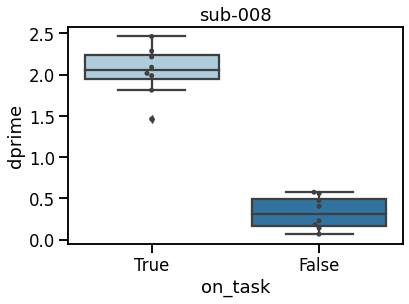

In [85]:
fig,axs=plt.subplots(1,1)

sns.boxplot(x='on_task',y='dprime', order=[True,False],data=summary)
sns.swarmplot(x='on_task',y='dprime', order=[True,False],data=summary,color='.25',size=5)
axs.set_title(f'{sub}')
plt.show()

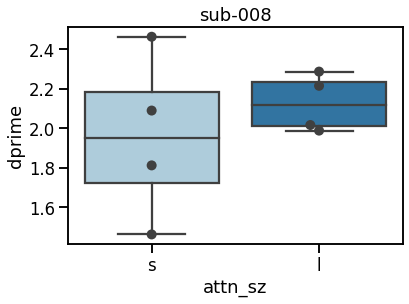

In [84]:
fig,axs=plt.subplots(1,1)

sns.boxplot(x='attn_sz',y='dprime',data=summary[summary.on_task == True])
sns.swarmplot(x='attn_sz',y='dprime',data=summary[summary.on_task == True],color='.25',size=10)
axs.set_title(f'{sub}')
plt.show()

<AxesSubplot:title={'center':'dprime'}, xlabel='[attn_sz, on_task]'>

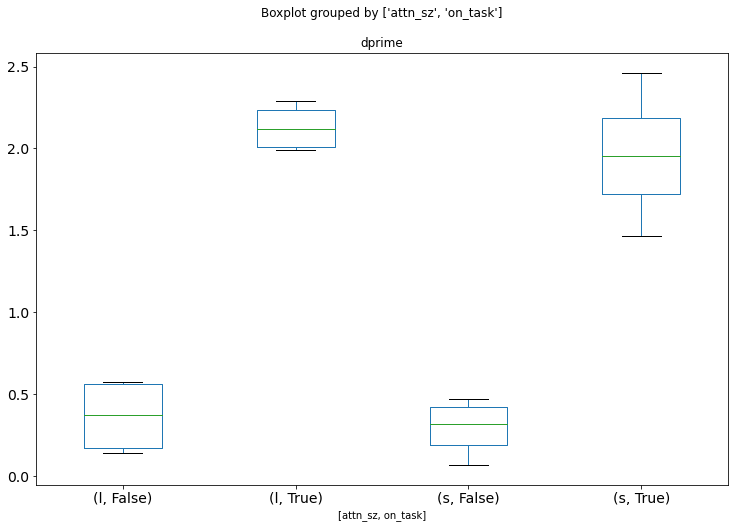

In [3]:
s_df = summary[summary.attn_sz == 'l']
l_df = summary[summary.attn_sz == 's']
x = np.ones(len(s_df))*1
x = np.append(x,np.ones(len(l_df))*2)

summary.boxplot(column=['dprime'], by=['attn_sz','on_task'], grid=False,figsize=(12,8), fontsize=14)

# plt.scatter(x,[s_df.dprime,l_df.dprime])
# plt.savefig('criterion_boxplot.png', dpi=300)

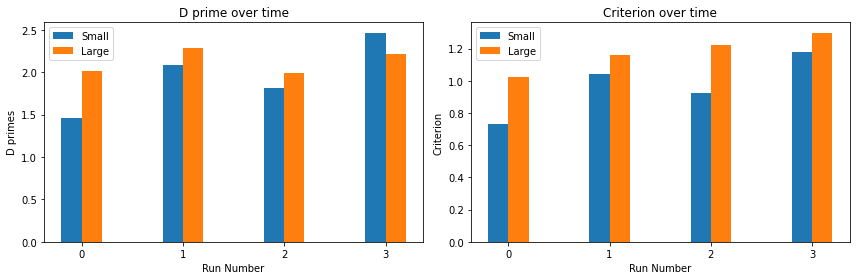

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

labels = summary.run.unique()

x = np.arange(len(labels)/2)  # the label locations
width = 0.2  # the width of the bars

rects1 = ax[0].bar(x - width/2, summary[(summary.attn_sz == 's') & summary.on_task].dprime, width, label='Small')
rects2 = ax[0].bar(x + width/2, summary[(summary.attn_sz == 'l') & summary.on_task].dprime, width, label='Large')

ax[0].set_ylabel('D primes')
ax[0].set_xlabel('Run Number')
ax[0].set_title('D prime over time')
ax[0].set_xticks(x)
# ax[0].set_xticklabels(labels)
ax[0].legend()

rects1 = ax[1].bar(x - width/2, summary[(summary.attn_sz == 's') & summary.on_task].criterion, width, label='Small')
rects2 = ax[1].bar(x + width/2, summary[(summary.attn_sz == 'l') & summary.on_task].criterion, width, label='Large')

ax[1].set_ylabel('Criterion')
ax[1].set_xlabel('Run Number')
ax[1].set_title('Criterion over time')
ax[1].set_xticks(x)
# ax[1].set_xticklabels(labels)
ax[1].legend(loc='best')

fig.tight_layout()

plt.show()